In [1]:
# spam_classifier.py
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from imblearn.over_sampling import SMOTE

In [2]:
# Download NLTK data (run once)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [3]:
# Step 1: Load the dataset
data = pd.read_csv('data/emails.csv')

# Explore the dataset
print("Column Headers:", data.columns.tolist())
print("Data Types:\n", data.dtypes)
print("Null Values:\n", data.isnull().sum())

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
data['processed_text'] = data['text'].apply(preprocess_text)

Column Headers: ['text', 'spam']
Data Types:
 text    object
spam     int64
dtype: object
Null Values:
 text    0
spam    0
dtype: int64


In [4]:
# Step 2: Split the dataset into 80% train / 20% test
X = data['processed_text']
y = data['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 4582
Test set size: 1146


In [5]:
# Step 3: Oversample minority class on train set
temp_vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = temp_vectorizer.fit_transform(X_train).toarray()
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)
print("\nPost-Oversampling Train Label Distribution:")
print(pd.Series(y_train_res).value_counts())

c:\Users\This PC\.conda\envs\spam_detector\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Post-Oversampling Train Label Distribution:
spam
0    3504
1    3504
Name: count, dtype: int64


In [6]:
# Step 4: Pipeline for TF-IDF + SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(random_state=42, class_weight='balanced'))
])

In [7]:
# Step 5: GridSearchCV with cross-validation on train set
param_grid = {
    'tfidf__max_features': [3000, 5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Print best params and top 5 CV results
print("\nBest Params:", grid_search.best_params_)
cv_results = pd.DataFrame(grid_search.cv_results_)
top_5 = cv_results[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False).head()
print("Top 5 Hyperparameter Combos:\n", top_5)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   3.9s
[CV] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   3.8s
[CV] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   3.8s
[CV] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   3.8s
[CV] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   3.7s
[CV] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear, tfidf__max_features=3000, tfidf__ngram_range=(1, 2); total time=   4.9s
[CV] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear, tfidf__max_features=3000, tfidf__ngram_range=(1, 2); total time=   4.9s
[CV] END svm__C=0.1, 

In [8]:
# Step 6: Evaluate on test set only
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")


Test Metrics:
Accuracy: 0.9913
Precision: 0.9895
Recall: 0.9759
F1-Score: 0.9826


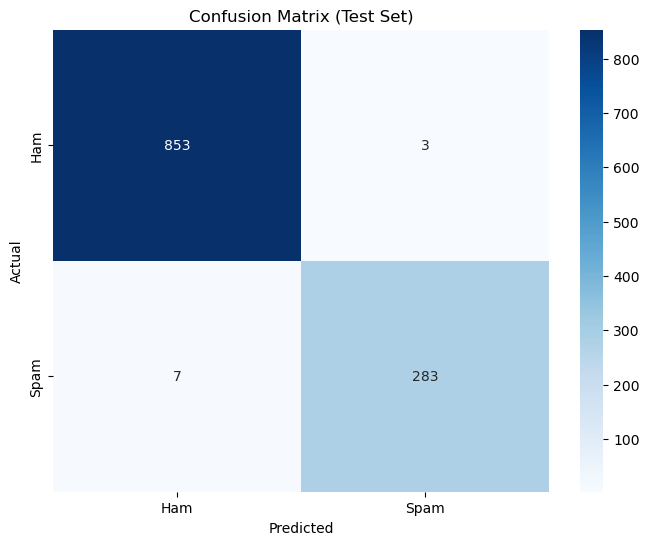

In [9]:
# Step 7: Visualize confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
# Step 8: Save model and vectorizer
joblib.dump(best_model, 'spam_classifier_model.joblib')
joblib.dump(best_model.named_steps['tfidf'], 'tfidf_vectorizer.joblib')

# Example prediction
sample_email = "Win a free iPhone now! Click here to claim your prize!"
processed_email = preprocess_text(sample_email)
prediction = best_model.predict([processed_email])
print("\nSample Email Prediction:")
print("Spam" if prediction[0] == 1 else "Ham")  


Sample Email Prediction:
Spam
